<a href="https://colab.research.google.com/github/oscarcortez/colaboratory-projects/blob/main/robot_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# dataframes and queries
import pandas as pd 
# math
import numpy as np 
# draw charts
from matplotlib import pyplot as plt
# web scraping
from bs4 import BeautifulSoup
import requests
import html5lib
from urllib.request import urlopen
#para convertir currency a number
from re import sub
# import companies historial actions values
import yfinance as yf
# datetimes
from datetime import datetime
# clear output
import os
# for delay
import time
# for clear screen output
from IPython.display import clear_output

In [2]:
class stock_exchange:
  
  def import_base_bitcoin(self):  
    
    df_bitcoin = yf.download(tickers = "BTC-USD", period = "7d", interval = "5m")
    df_bitcoin = df_bitcoin[['Close','Volume']].query("Close != 0 and Volume != 0").drop_duplicates()
    self.df_bitcoin = df_bitcoin

  def extract_trend(self):
    
    url = 'https://coinmarketcap.com/'
    page = requests.get(url)
    soup = BeautifulSoup(page.content,'html.parser')
    tendencia_classname_converter = {'icon-Caret-up':'High','icon-Caret-down':'Low'}
    table = soup.findAll('table', class_="sc-beb003d5-3 ieTeVa cmc-table")[0]
    companies = []
    for i, tr in enumerate(table.find_all('tr')):
      company = {}
      if tr.find('p', class_="sc-4984dd93-0 kKpPOn") is None:
        company['name'] = tr.find_all('span')[3].get_text()
        # print(tr.find_all('div', class_='sc-cadad039-0 clgqXO')) # DONT WORK
        # print(tr.find_all('td')[3].get_text()) # DONT WORK - price
        for i, td in enumerate(tr.find_all('td')):
          if i == 3:
            company['price'] = float(sub(r'[^\d.]', '', td.get_text()))
        # print(tr.find_all('span', class_='sc-97d6d2ca-0 bQjSqS')) # trend don't work
      else: # first 9 rows
        company['name'] = tr.find('p', class_="sc-4984dd93-0 kKpPOn").get_text()
        company['price'] = float(sub(r'[^\d.]', '', tr.find('div', class_='sc-cadad039-0 clgqXO').a.span.get_text()))
        company['trend'] = tendencia_classname_converter [tr.find('span', class_='sc-97d6d2ca-0').span.attrs['class'][0]]

      companies.append(company)

    df_table = pd.DataFrame(companies)
    company, self.current_price, self.current_trend = df_table.query("name == 'Bitcoin'").values.flatten().tolist()
  
  def clean_data(self):
    
    df_bitcoin_close = self.df_bitcoin['Close']
    Q1 = df_bitcoin_close.quantile(.25)
    Q3 = df_bitcoin_close.quantile(.75)
    IIQ = Q3 - Q1
    self.lower_limit = Q1 - 1.5 * IIQ
    self.upper_limit = Q3 + 1.5 * IIQ
    self.df_bitcoin_cleaned = self.df_bitcoin.query(f'Close >= {self.lower_limit} and Close <= {self.upper_limit}')
  
  def take_decision(self):

    self.mean_company, self.max_company, self.min_company, self.count_company = self.df_bitcoin_cleaned.describe()[['Close']].T[['mean','max','min','count']].values.flatten().tolist()
    self.decision = 'No Action'
    if self.current_price >= self.mean_company and self.current_trend == 'Low':
      self.decision = 'Sell'
    elif self.current_price < self.mean_company and self.current_trend == 'High':
      self.decision = 'Buy'
    print(self.decision)

  def visualization(self):
    
    today = datetime.now()
    plt.plot()
    plt.plot(self.df_bitcoin_cleaned.index, self.df_bitcoin_cleaned['Close'])
    self.df_bitcoin_cleaned=self.df_bitcoin_cleaned.assign(Mean=self.mean_company)
    plt.plot(self.df_bitcoin_cleaned.index, self.df_bitcoin_cleaned['Mean'])
    plt.title('Bitcoin Price ($)')
    plt.xlabel('Dates')
    plt.ylabel('Amount ($)')
    plt.rcParams["figure.figsize"] = (12,6)
    
    print(f'Execution time: {today.strftime("%d/%m/%Y %H:%M:%S")}')
    print(f'precio promedio bitcoin: {self.mean_company}')
    print(f'precio actual: {self.current_price}')
    print(f'Tendencia: {self.current_trend}')
    print(f'Action: {self.decision}')
    plt.show()

  def automate(self, minutes):

    while(True):
      clear_output()
      self.import_base_bitcoin()
      self.extract_trend()
      self.clean_data()
      self.take_decision()
      self.visualization()
      time.sleep(minutes * 60)


se = stock_exchange()


In [3]:
se.import_base_bitcoin()
se.df_bitcoin

[*********************100%***********************]  1 of 1 completed


,Close,Volume
Datetime,,
2023-05-10 00:15:00+00:00,27707.296875,19240960
2023-05-10 00:20:00+00:00,27745.181641,17082368
2023-05-10 00:25:00+00:00,27745.185547,50907136
2023-05-10 00:30:00+00:00,27741.419922,33784832
2023-05-10 00:35:00+00:00,27774.273438,31753216
...,...,...
2023-05-15 12:30:00+00:00,27357.208984,3696640
2023-05-15 12:35:00+00:00,27384.978516,9203712
2023-05-15 12:40:00+00:00,27408.583984,9104384


In [4]:
se.extract_trend()

<Axes: >

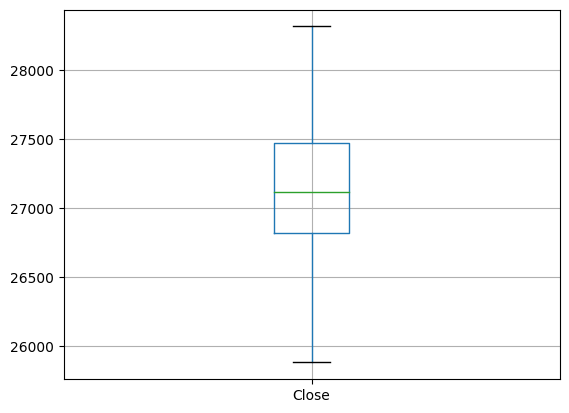

In [5]:
se.df_bitcoin.boxplot(['Close'])

In [6]:
se.clean_data()

In [7]:
print(se.lower_limit, se.upper_limit)
nuevo = se.df_bitcoin.query(f'Close < {se.lower_limit} or Close > {se.upper_limit}')
nuevo

25839.969970703125 28448.100830078125


,Close,Volume
Datetime,,


<Axes: >

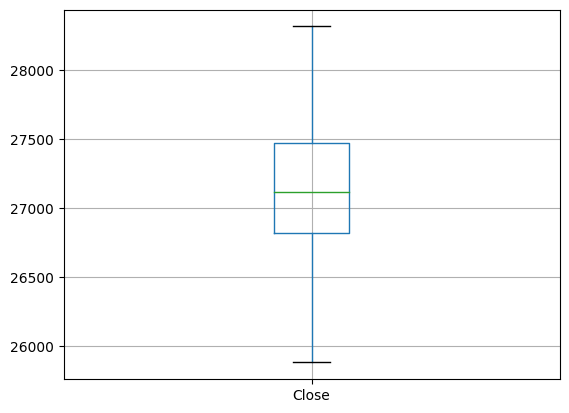

In [8]:
se.df_bitcoin_cleaned.boxplot(['Close'])

In [9]:
se.take_decision()

Buy


Execution time: 16/05/2023 15:27:55
precio promedio bitcoin: 27125.832917436535
precio actual: 27038.87
Tendencia: High
Action: Buy


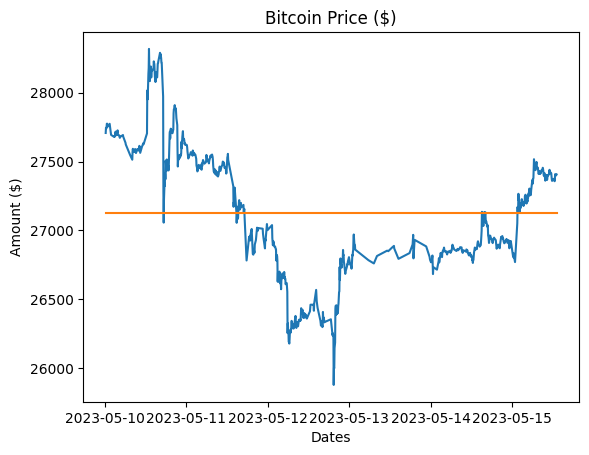

In [10]:
se.visualization()

[*********************100%***********************]  1 of 1 completed
Buy
Execution time: 16/05/2023 15:27:56
precio promedio bitcoin: 27125.832917436535
precio actual: 27038.87
Tendencia: High
Action: Buy


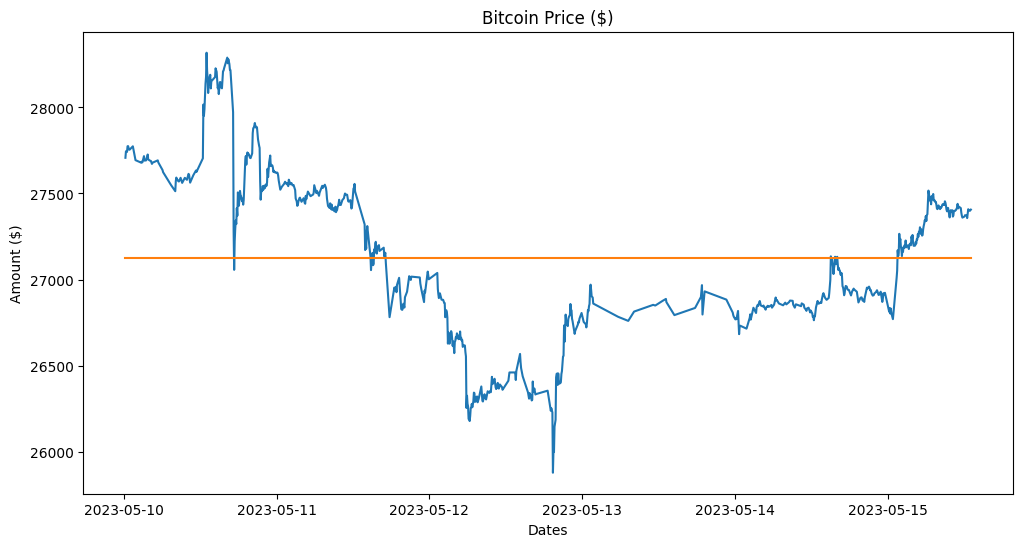

In [ ]:
se.automate(minutes = 5)